# Section 5 of self-driving car course

In [1]:
# Imports

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions

def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny


def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([
    [(200, height), (1100, height), (550, 250)]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image


def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image


def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (3/5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])


def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    if lines is None:
        return None
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    # add more weight to longer lines
    left_fit_average  = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line  = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    averaged_lines = [left_line, right_line]
    return averaged_lines

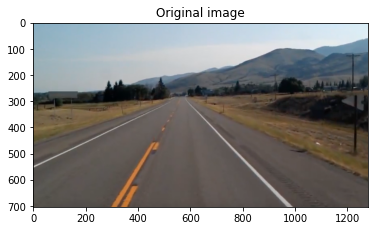

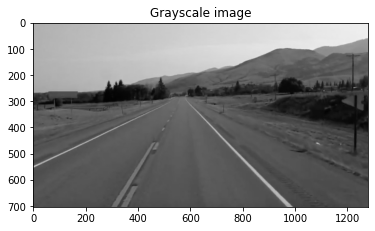

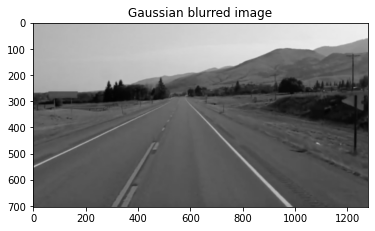

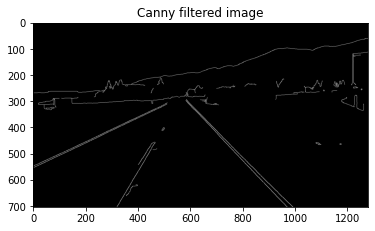

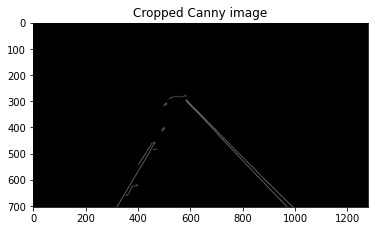

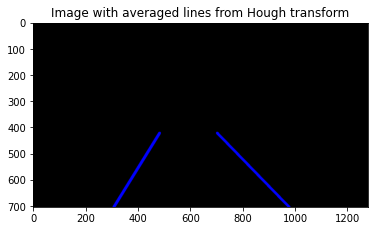

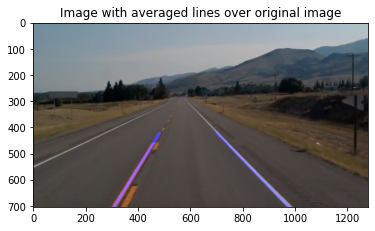

In [14]:
# Image things

image = cv2.imread('test_image.jpg')
lane_image = np.copy(image) # copy is important, so we dont overwrite changes
canny_image = canny(image)
cropped_image = region_of_interest(canny_image)

# 2 is number of pixels in rho-bin, np.pi/180 is number of degrees in angle bin
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
averaged_lines = average_slope_intercept(lane_image, lines)

averaged_lines_image = display_lines(lane_image, averaged_lines)

combo_image = cv2.addWeighted(lane_image, 0.8, averaged_lines_image, 1, 1)

#cv2.imshow("result", combo_image)
#cv2.waitKey(0)

plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # Convert the color image from BGR (cv2 default) to RGB
plt.title('Original image')
plt.show()

grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(cv2.cvtColor(grayscale, cv2.COLOR_BGR2RGB)) 
plt.title('Grayscale image')
plt.show()

gaussian_image = cv2.GaussianBlur(grayscale, (5,5), 0)
plt.figure()
plt.imshow(cv2.cvtColor(gaussian_image, cv2.COLOR_BGR2RGB)) 
plt.title('Gaussian blurred image')
plt.show()

plt.figure()
plt.imshow(cv2.cvtColor(canny_image, cv2.COLOR_BGR2RGB)) 
plt.title('Canny filtered image')
plt.show()

plt.figure()
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)) 
plt.title('Cropped Canny image')
plt.show()

plt.figure()
plt.imshow(cv2.cvtColor(averaged_lines_image, cv2.COLOR_BGR2RGB)) 
plt.title('Image with averaged lines from Hough transform')
plt.show()

plt.figure()
plt.imshow(cv2.cvtColor(combo_image, cv2.COLOR_BGR2RGB)) 
plt.title('Image with averaged lines over original image')
plt.show()


In [11]:
# Video things



cap = cv2.VideoCapture("test2.mp4")

# out is used to save the video as mp4 file
#fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (1280,720))
counter = 0


while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if counter > 200:
            break
        canny_image = canny(frame)
        cropped_image = region_of_interest(canny_image)

        # 2 is number of pixels in rho-bin, np.pi/180 is number of degrees in angle bin
        lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
        averaged_lines = average_slope_intercept(frame, lines)

        line_image = display_lines(frame, averaged_lines)

        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
        #out.write(combo_image)
        cv2.imshow("result", combo_image)
        if cv2.waitKey(1) & 0xFF == ord('q'): # 1 ms
            break
        counter += 1
    else: 
        break
cap.release()
#out.release()
cv2.destroyAllWindows()